# "Galfitting" with lenstronomy
An example of using **lenstronomy** without imposing a lensing deflector is the inference of galaxy structural parameters through the fitting of a parameterized surface brightness model (or many thereof).

We want to demonstrate the flexibility of **lenstronomy**. Matching the structural properties of lensing and source galaxy is an integral part of lens modelling. **lenstronomy** may provide an alternative in python to other software that are more specific to this task.
The 'lens_light_model' effectively describes undistorted surface brightness profiles in lenstronomy.

**lenstronomy** supports a wide range of light profiles. You can find the current list here: https://github.com/sibirrer/lenstronomy/blob/master/lenstronomy/LightModel/light_model_base.py

A key difference to other ligth profile fitting codes is that **lenstronomy** solves the amplitude parameter of the different components with a linear minimizer on the fly. An arbitrary number of superposition of different profiles is supported, including shapelets and wavelets, to describe complex structure.

**lenstronomy** also supports multi-band, multi-exposure, and multi-object fitting. We refer to other notebooks about the handling of those tasks. In short, all the tasks that are supported when using lenstronomy in the 'lensing model' are also supported when turning lensing off - with the identical API.

<div class="alert alert-warning">

**Warning:** Small sources and very cuspy cores (such as Sersic profiels with high Sersic indexes) result in steep surface brightness variations below the pixel scale. The numerics used in this notebook only evaluates the surface brighness in the centre of each pixel and assigns the entire pixel this surface brightness value. Super-sampled evaluation of surface brightness profiles may be required. Lenstronomy supports this, both on a grid and adaptive in specific regions. We refer to the $\texttt{Numerics}$ module and a dedicated notebook on numerical aspects.

</div>

Additional features are available with the software [GaLight](https://github.com/dartoon/galight), which wrapps around lenstronomy.


In [2]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

In [4]:
import h5py
import os

def import_data(filter_name):
    
    data_file = os.path.join('/Volumes/T7/AGEL_data/16773/cutout/DCLS1507+0522/', 'image_DCLS1507+0522_{}_galaxy2.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    # get data and PSF estimate from file
    psf_file = os.path.join('/Volumes/T7/AGEL_notebooks/GitHub/compound_lens_dcls1507/PSF files/', 'psf_model_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

/Users/hskobe/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_96090/2197373808.py:14: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)


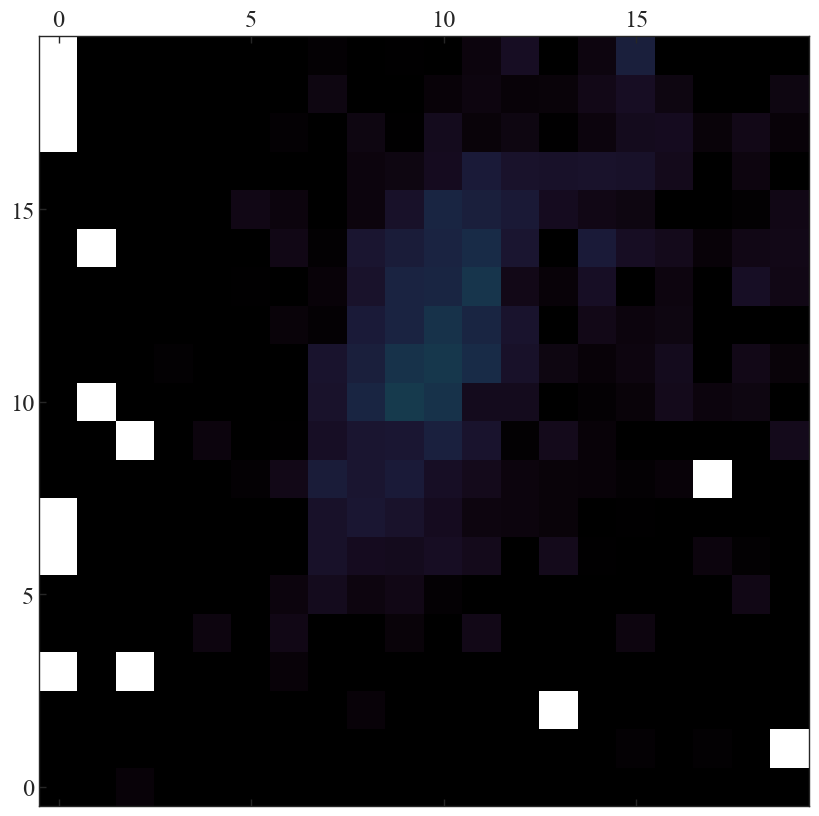

In [5]:
from lenstronomy.Data.coord_transforms import Coordinates

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_F200LP['image_data']
numPix = len(data_cutout)

ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)
ax.autoscale(False)

lens_center_ra, lens_center_dec = kwargs_data_F200LP['ra_shift'], kwargs_data_F200LP['dec_shift']

#plt.colorbar()
plt.show()

In [16]:
deltaPix = coords.pixel_width
lens_bound = 0.2

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'HERNQUIST_ELLIPSE']

# here we super-sample the resolution of some of the pixels where the surface brightness profile has a high gradient 
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[37:41, 37:41] = True

kwargs_numerics = {'supersampling_factor': 4, 
                   'compute_mode': 'adaptive',
                  'supersampled_indexes': supersampled_indexes}

In [24]:
kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']],  
                                                           [0, 1, ['e1', 'e2', 'n_sersic']],
                                                           [0, 2, ['center_x', 'center_y']],  
                                                           [0, 2, ['e1', 'e2']]]}
kwargs_likelihood = {'check_bounds': True}

image_band = [kwargs_data_F200LP, kwargs_psf_F200LP, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [25]:
# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []
joint_lens_light_with_lens_light = []
lens_light_index_with_centroid = 0

joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list)-1, ['center_x', 'center_y']])
joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list)-1, ['e1', 'e2', 'n_sersic']])


# first Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.1537128063740176, 'n_sersic': 4, 'e1': 0.29993438497866304, 'e2': 0.2999125914597888, 'center_x': lens_center_ra, 'center_y': lens_center_dec})
kwargs_lens_light_sigma.append({'n_sersic': 0.15, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.05/10, 'center_y': 0.05/10})
kwargs_lower_lens_light.append({'e1': -0.3, 'e2': -0.3, 'R_sersic': 0.1, 'n_sersic': 0.5, 'center_x': lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound})
kwargs_upper_lens_light.append({'e1': 0.3, 'e2': 0.3, 'R_sersic': 10, 'n_sersic': 8, 'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound})


# second Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.1, 'n_sersic': 4, 'e1': 0.29993438497866304, 'e2': 0.2999125914597888, 'center_x': lens_center_ra, 'center_y': lens_center_dec})
kwargs_lens_light_sigma.append({'n_sersic': 0.15, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.05/10, 'center_y': 0.05/10})
kwargs_lower_lens_light.append({'e1': -0.3, 'e2': -0.3, 'R_sersic': 0.1, 'n_sersic': 0.5, 'center_x': lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound})
kwargs_upper_lens_light.append({'e1': 0.3, 'e2': 0.3, 'R_sersic': 10, 'n_sersic': 8, 'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'sigma0': 5, 'Rs': 0.7, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'sigma0': 0.5, 'Rs': 0.3, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens_light.append({'sigma0': 0.01,'Rs': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'sigma0': 10,'Rs': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .5, 'n_particles': 200, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()



Computing the PSO ...


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.4779737289344086 reduced X^2 of best position
-287.46589027774246 log likelihood
389.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.19550159357234936, 'n_sersic': 1.0097505822160198, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}, {'amp': 1, 'R_sersic': 0.19553895711346567, 'n_sersic': 1.0097505822160198, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}, {'amp': 1, 'Rs': 9.999996552133029, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}] lens light result
[] point source result
{} special param result
40.74555015563965 time used for  PSO


-1.437329453080353 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.4373294602096818


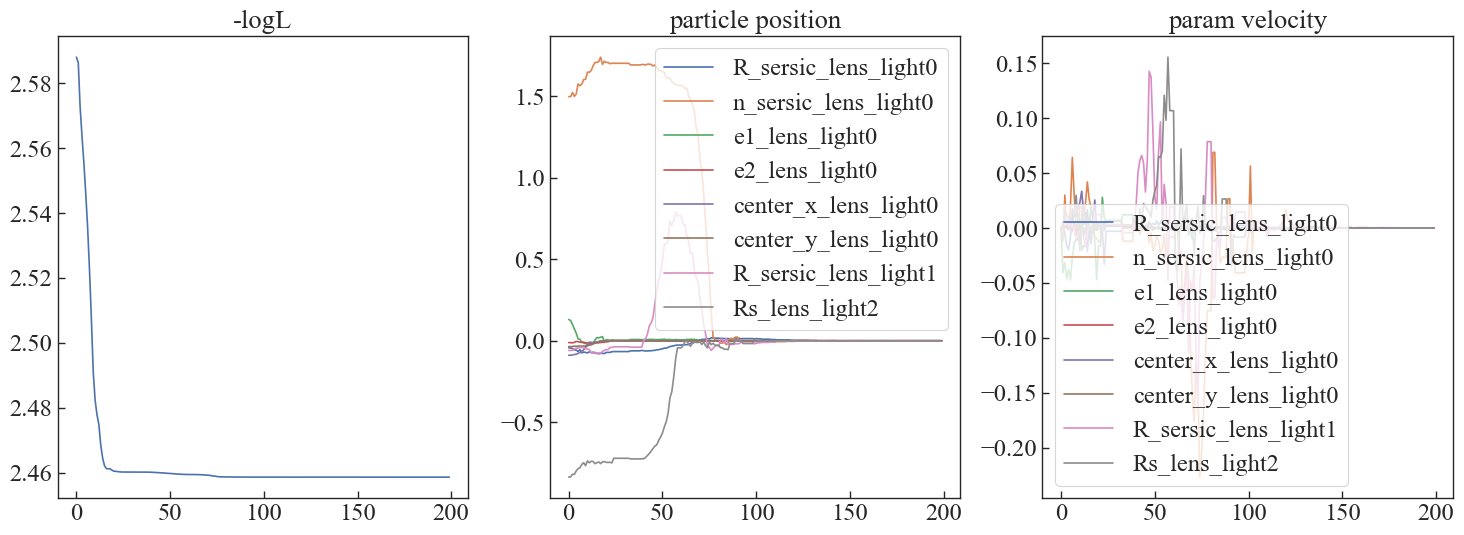

<Figure size 640x480 with 0 Axes>

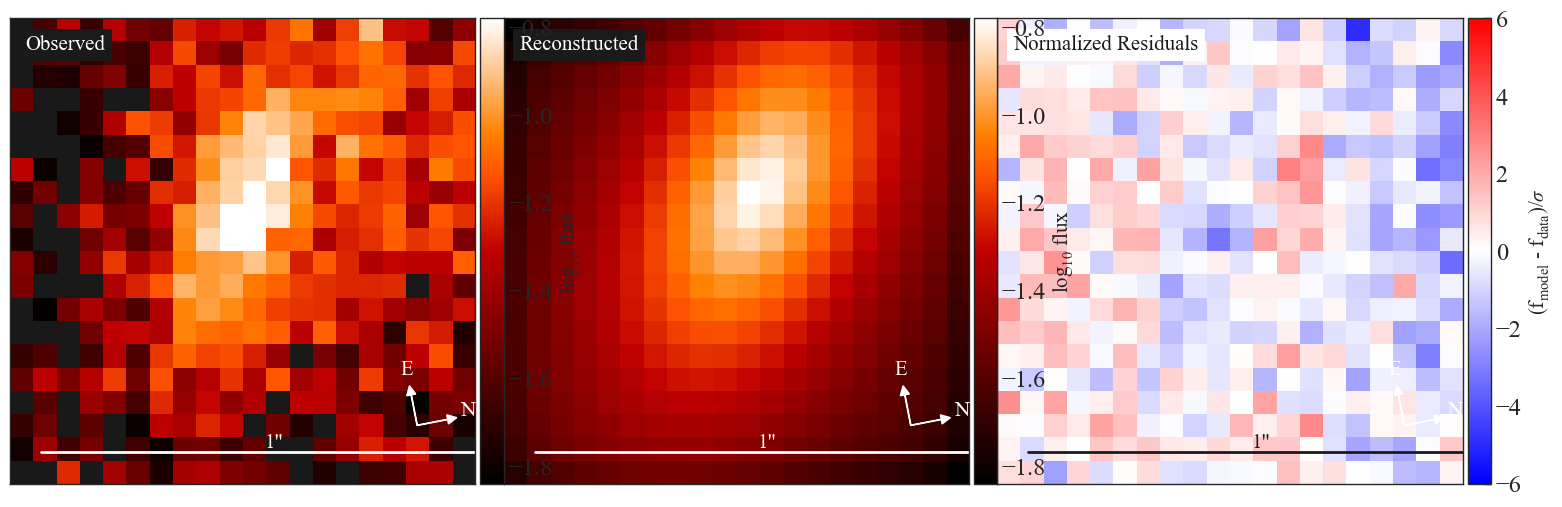

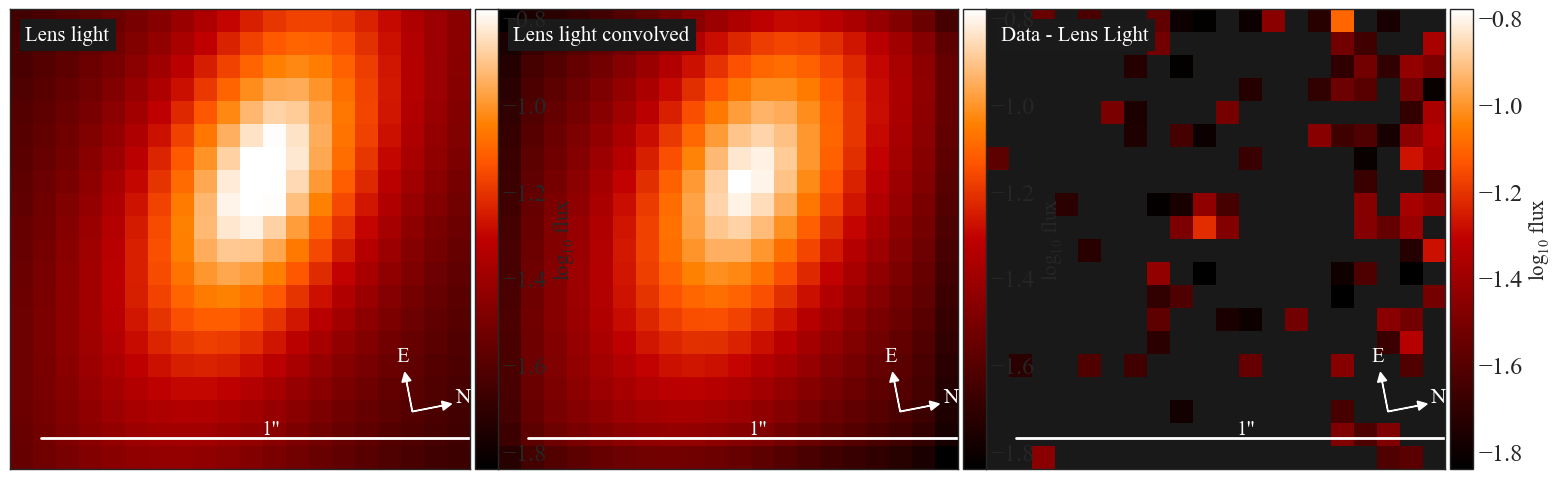

[{'amp': -23627.18880680606, 'R_sersic': 0.19550159357234936, 'n_sersic': 1.0097505822160198, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}, {'amp': 23639.786967874174, 'R_sersic': 0.19553895711346567, 'n_sersic': 1.0097505822160198, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}, {'amp': 2.5927721064113354, 'Rs': 9.999996552133029, 'e1': 0.10771857225870478, 'e2': 0.29999999961976165, 'center_x': 0.09879258465034393, 'center_y': 0.03949003659311043}]


In [26]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result['kwargs_lens_light'])